# Performance comparison

In [34]:
import os
import random
import time
import yaml
import pickle
from pathlib import Path
import json
import copy
import re


import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta


# set random seed
seed = 42
np.random.seed(seed)
random.seed(seed)


## Load

In [35]:
experiment_folder_name = 'pilot'
experiment_folder = MODELS_DIR / experiment_folder_name

split = 0 # first split
relative_path = f'{split}_split/'

plots_folder = FIGURES_DIR / 'experiments' / experiment_folder_name
plots_folder.mkdir(exist_ok=True, parents=True)


# Dictionary to store the results
runs = {}


In [36]:
experiment_names = [] # handle duplicates
lowest_steps_ahead = np.inf # ensure no index error
# iterate each run
for experiment_name in sorted(os.listdir(experiment_folder)):
    if experiment_name.startswith('.'):
        print(f'Skipping {experiment_name}')
        continue

    try:
        results = {}
        save_folder = MODELS_DIR / experiment_folder_name / experiment_name

        # Get relevant indo
        config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
        split_info = pickle.load(open(save_folder / 'split_info.pkl', 'rb'))
        run_folder = Path(config['split_folders'][split])
        run_info = split_info[split]    
        eval_folder = run_folder / 'evaluation'

        # Load the split info
        best_model_path = run_info['best_model_path']
        epoch = int(re.search(r'epoch=(\d+)', best_model_path).group(1))
        results['epoch'] = epoch
        results['training_time'] = run_info['training_time']
        
        # Handle the experiment name (in case of duplicates)
        #experiment_name = config['experiment_name']
        if experiment_name not in experiment_names:
            results['experiment_name'] = experiment_name
            experiment_names.append(experiment_name)
        else:
            print(f'Warning: {experiment_name} already exists')
            experiment_names.append(experiment_name)
            # count occurrences of name
            count = sum([1 for name in experiment_names if name == experiment_name])
            experiment_name = f'{experiment_name} ({count})'
            results['experiment_name'] = experiment_name


        data_types = ['val', 'test']
        for data_type in data_types:
            results[data_type] = {}
            step_MAEs = pd.read_csv(eval_folder / data_type / 'step_MAEs.csv', index_col=0)
            results[data_type]['step_MAEs'] = step_MAEs
            condition_MAEs = pd.read_csv(eval_folder / data_type / 'condition_MAEs.csv', index_col=[0, 1])
            results[data_type]['condition_MAEs'] = condition_MAEs
        
        # get the lowest steps ahead
        lowest_steps_ahead = min(lowest_steps_ahead, max(step_MAEs.index))
        runs[experiment_name] = results
        print(f'Loaded {experiment_name}')  

    except Exception as e:
        print(f'Error loading {experiment_name}: {e}')
        continue


print(f'Lowest steps ahead: {lowest_steps_ahead}')

Loaded engineering=day_of_week_241211_2259
Loaded engineering=time_of_day_241212_0831
Loaded function_transform_type=log_241212_1017
Loaded function_transform_type=sqrt_241212_1213
Loaded scaler_type=min-max_241212_0846
Loaded scaler_type=standard_241212_1027
Lowest steps ahead: 10


## 1 step ahead

In [37]:
data_type = 'val'

In [38]:
# create the dataframe
data = []

round_to = 5
for run in runs:
    experiment_name = runs[run]['experiment_name']
    step_MAEs = runs[run][data_type]['step_MAEs']
    overall_1_step = round(step_MAEs.loc[1, 'Overall'], round_to)
    data.append({
        #'run': run,
        'Experiment': f"{experiment_name}",
        '1-step MAE': overall_1_step,
        #'date': run,
    })

df = pd.DataFrame(data)
df = df.sort_values(by='1-step MAE', ascending=True)
df

,Experiment,1-step MAE
2,function_transform_type=log_241212_1017,0.00052
4,scaler_type=min-max_241212_0846,0.00052
3,function_transform_type=sqrt_241212_1213,0.00053
5,scaler_type=standard_241212_1027,0.00055
1,engineering=time_of_day_241212_0831,0.00058
0,engineering=day_of_week_241211_2259,0.00090


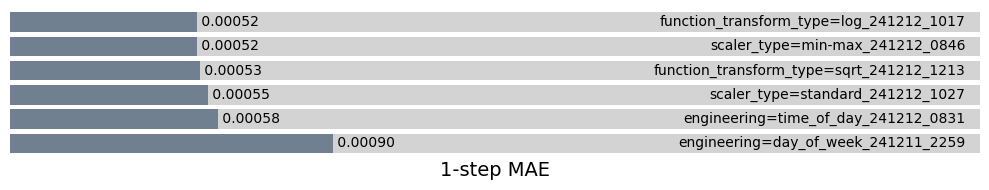

In [39]:
# plot the results
plt.figure(figsize=(10, 2))
# the highest value should be 1/3 of the bar width (to leave space for the text)
highest_value = df['1-step MAE'].max()
ax = sns.barplot(data=df, y='Experiment', x=[highest_value*3] * len(df), color='lightgrey', saturation=1) # create the background bars
sns.barplot(data=df, y='Experiment', x='1-step MAE', color='slategrey', saturation=1, ax=ax)

for lbl in ax.get_yticklabels():
     # add the y tick labels as right aligned text into the plot
     ax.text(0.985, lbl.get_position()[1], lbl.get_text(), transform=ax.get_yaxis_transform(), ha='right', va='center')
ax.bar_label(ax.containers[1], fmt=f' %.{round_to}f', label_type='edge') # add the values on the right side of the bars
ax.set_xticks([]) # remove the x ticks
ax.set_yticks([]) # remove the y ticks
ax.set_ylabel('') # remove the y label
#ax.xaxis.label.set_visible(False)
ax.xaxis.set_label('1-step MAE')
# adjust size of the x axis
ax.xaxis.label.set_size(14)
ax.margins(x=0) # remove the spacing at the right
sns.despine(left=True, bottom=True) # remove the spines
plt.tight_layout()
# save the plot
plt.savefig(plots_folder / 'overall_1_step_MAE.png', dpi=150)
plt.show()


## MAE as a function of steps ahead

In [40]:
# create the dataframe
data = np.zeros((lowest_steps_ahead, len(runs))) # (experiments, steps ahead) similar to (rows, columns)

round_to = 5
for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    step_MAEs = runs[run][data_type]['step_MAEs']
    data[:, i] = step_MAEs['Overall'].values

df = pd.DataFrame(data, columns=[f"{runs[run]['experiment_name']}" for run in runs], index=range(1, lowest_steps_ahead+1))
# sort columns by lowest 1-step MAE
df = df[df.loc[1].sort_values().index]
df

,scaler_type=min-max_241212_0846,function_transform_type=log_241212_1017,function_transform_type=sqrt_241212_1213,scaler_type=standard_241212_1027,engineering=time_of_day_241212_0831,engineering=day_of_week_241211_2259
1,0.000519,0.000522,0.000527,0.000551,0.000578,0.000895
2,0.001495,0.001517,0.001961,0.001616,0.001793,0.002340
3,0.002040,0.002065,0.002554,0.002189,0.002488,0.003310
4,0.002279,0.002447,0.002854,0.002437,0.002860,0.003882
5,0.002524,0.002699,0.003268,0.002663,0.003223,0.004457
6,0.002823,0.003023,0.003510,0.002859,0.003562,0.005008
7,0.003017,0.003204,0.003870,0.003017,0.003940,0.005551
8,0.003175,0.003344,0.004100,0.003150,0.004239,0.006030
9,0.003407,0.003466,0.004352,0.003299,0.004551,0.006533
10,0.003522,0.003623,0.004557,0.003452,0.004818,0.007015


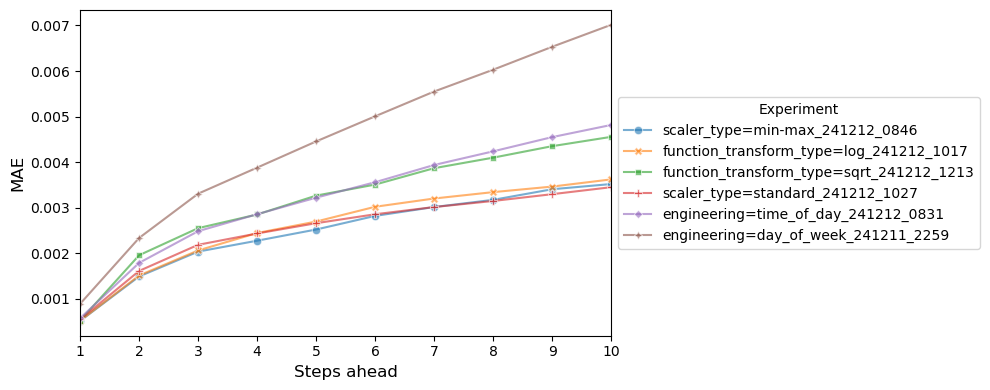

In [41]:
# Visualize the MAEs
plt.figure(figsize=(10, 4))
# plot the MAEs
sns.lineplot(data=df, alpha=0.6, dashes=False, markers=True)
plt.xticks(range(1, lowest_steps_ahead+1))
plt.xlim(1, lowest_steps_ahead)
#plt.legend(loc='lower center', ncol=len(runs), bbox_to_anchor=(0.5, -0.5), fontsize=10, title='Experiment')
# place a legend outside the plot on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='Experiment')
plt.xlabel('Steps ahead', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.tight_layout()
# save the plot
plt.savefig(plots_folder / 'overall_steps_ahead_MAE.png', dpi=150)
plt.show()


## Conditions and 1 step ahead

In [42]:
# create the dataframe
df = pd.DataFrame()

for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    condition_MAEs = runs[run][data_type]['condition_MAEs']
    condition_1_step_overall = condition_MAEs.loc[1, ['Overall']].rename(columns={'Overall': experiment_name}).T
    df = pd.concat([df, condition_1_step_overall])

n_conditions = df.shape[1]
# sort rows by overall 1-step MAE column
df = df.sort_values(by='Overall', axis=0)
df

Condition,Overall,Rain,Extreme,Dry
scaler_type=min-max_241212_0846,0.000519,0.000814,0.001423,0.000428
function_transform_type=log_241212_1017,0.000522,0.000801,0.001396,0.000431
function_transform_type=sqrt_241212_1213,0.000527,0.000839,0.001459,0.000432
scaler_type=standard_241212_1027,0.000551,0.000840,0.001459,0.000452
engineering=time_of_day_241212_0831,0.000578,0.000954,0.001778,0.000460
engineering=day_of_week_241211_2259,0.000895,0.001051,0.001574,0.000795


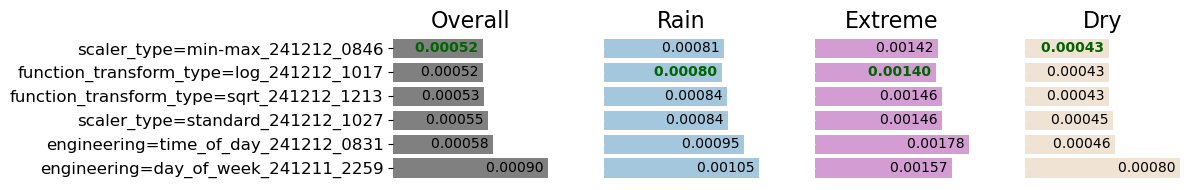

In [43]:
# Create a figure with an additional column for averages
fig, axs = plt.subplots(1, n_conditions, figsize=(12, 2))

for i, condition in enumerate(df.columns):
    sns.barplot(data=df, y=df.index, x=condition, ax=axs[i], saturation=0.5, color = condition_to_meta[condition]['color'])
    # add tooltips
    # Add tooltips on the opposite side of the bars
    lowest_value = df[condition].min()
    for j, value in enumerate(df[condition]):
        color = 'black' if value != lowest_value else 'darkgreen'
        fontweight = 'normal' if value != lowest_value else 'bold'
        axs[i].text(value, j, f'{value:.{round_to}f} ', ha='right', va='center', fontsize=10, color=color, fontweight=fontweight)
    axs[i].set_title(condition, fontsize=16)
    axs[i].tick_params(axis='y', labelsize=12) if i == 0 else axs[i].tick_params(axis='y', labelsize=1, colors='white')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticks([])
    axs[i].margins(x=0)
    sns.despine(ax=axs[i], left=True, bottom=True)

plt.tight_layout()
plt.savefig(plots_folder / 'condition_1_step_MAE.png', dpi=150)
plt.show()


## Training time and epochs

In [44]:
runs[run][data_type]['step_MAEs'].loc[1, 'Overall']

0.0005505638980621

In [45]:
# create the dataframe
df = pd.DataFrame()

for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    epochs = runs[run]['epoch']
    training_time = runs[run]['training_time']
    _df = pd.DataFrame({
        'Experiment': experiment_name,
        'Epochs': epochs,
        'Training time': training_time,
        'Overall': runs[run][data_type]['step_MAEs'].loc[1, 'Overall']
    }, index=[experiment_name])

    df = pd.concat([df, _df])

# sort rows by overall 1-step MAE column
df = df.sort_values(by='Overall')
# set experiment as index
df = df.set_index('Experiment')
n_conditions = df.shape[1]
df

,Epochs,Training time,Overall
Experiment,,,
scaler_type=min-max_241212_0846,12,68.655714,0.000519
function_transform_type=log_241212_1017,12,65.635924,0.000522
function_transform_type=sqrt_241212_1213,9,52.134299,0.000527
scaler_type=standard_241212_1027,11,53.840382,0.000551
engineering=time_of_day_241212_0831,7,41.254591,0.000578
engineering=day_of_week_241211_2259,9,52.495974,0.000895


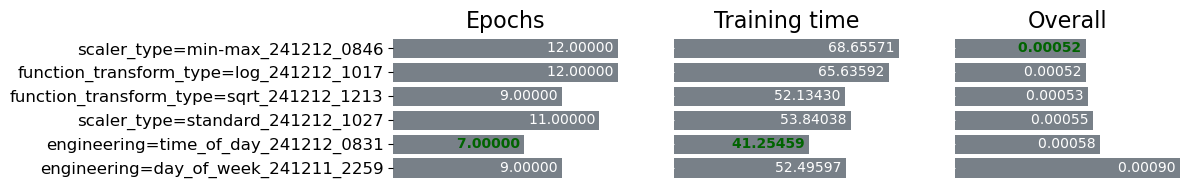

In [46]:
# Create a figure with an additional column for averages
fig, axs = plt.subplots(1, n_conditions, figsize=(12, 2))

for i, condition in enumerate(df.columns):
    sns.barplot(data=df, y=df.index, x=condition, ax=axs[i], saturation=0.5, color = 'slategrey')
    # add tooltips
    # Add tooltips on the opposite side of the bars
    lowest_value = df[condition].min()
    for j, value in enumerate(df[condition]):
        color = 'white' if value != lowest_value else 'darkgreen'
        fontweight = 'normal' if value != lowest_value else 'bold'
        axs[i].text(value, j, f'{value:.{round_to}f} ', ha='right', va='center', fontsize=10, color=color, fontweight=fontweight)
    axs[i].set_title(condition, fontsize=16)
    axs[i].tick_params(axis='y', labelsize=12) if i == 0 else axs[i].tick_params(axis='y', labelsize=1, colors='white')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticks([])
    axs[i].margins(x=0)
    sns.despine(ax=axs[i], left=True, bottom=True)

plt.tight_layout()
plt.savefig(plots_folder / 'condition_1_step_MAE.png', dpi=150)
plt.show()
